In [1]:
import astropy.units as u
import numpy as np
from BDFit import StarFit, find_bands, provide_phot
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os
from astropy.coordinates import SkyCoord, Galactocentric
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval, LinearStretch

In [2]:
s = StarFit(libraries=['ATMO2020'])

Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 418


In [3]:
cat_path = '/nvme/scratch/work/tharvey/catalogs/UNCOVER_DR3_LW_SUPER_catalog.fits'

table = Table.read(cat_path)

bands = find_bands(table, flux_wildcard=f'f_*')

bands_to_remove =  ['f105w', 'f125w', 'f140w', 'f160w', 'alma']
for band in bands_to_remove:
    bands.remove(band)

flux, error = provide_phot(bands=bands, flux_wildcard='f_*', error_wildcard='e_*', table=table, flux_unit=u.nJy)
# unit is 10*nJy
flux *= 10
error *= 10

s.fit_catalog(fnu=flux, efnu=error, bands=[band.upper() for band in bands], catalogue_ids=table['id'])

Warning! Assuming F435W is the same as ACS_WFC.F435W
Warning! Assuming F606W is the same as ACS_WFC.F606W
Warning! Assuming F814W is the same as ACS_WFC.F814W
Library ATMO2020 wavelength range: 0.30007502 um - 11.979605275010028 um
Fitting with ATMO2020 libraries with 418 templates.
Fitting 23 bands: ['ACS_WFC.F435W', 'ACS_WFC.F606W', 'ACS_WFC.F814W', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F360M', 'F410M', 'F430M', 'F444W', 'F460M', 'F480M']


/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1233: RuntimeWarning: invalid value encountered in divide
  star_tnorm = _num/_den
Calculating chi2 for all templates...: 100%|██████████| 418/418 [00:07<00:00, 54.92it/s]
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1258: RuntimeWarning: All-NaN slice encountered
  star_min_chi2 = np.nanmin(star_chi2, axis=1)
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1261: RuntimeWarning: divide by zero encountered in divide
  star_min_chinu = star_min_chi2 / (self.nusefilt - 1)
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1261: RuntimeWarning: invalid value encountered in divide
  star_min_chinu = star_min_chi2 / (self.nusefilt - 1)


{'subset': None,
 'star_tnorm': array([[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [2.30210817e+12, 1.34772330e+12, 3.14300927e+12, ...,
         2.15050794e+05, 2.07852587e+05, 1.94102277e+05],
        [1.78354098e+11, 9.02672144e+10, 3.98439807e+11, ...,
         1.64969658e+03, 1.68156892e+03, 1.70696715e+03],
        [1.39136185e+11, 6.90480254e+10, 4.89434362e+11, ...,
         1.72403681e+03, 1.76505605e+03, 1.79211395e+03]]),
 'star_chi2': array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        n

6


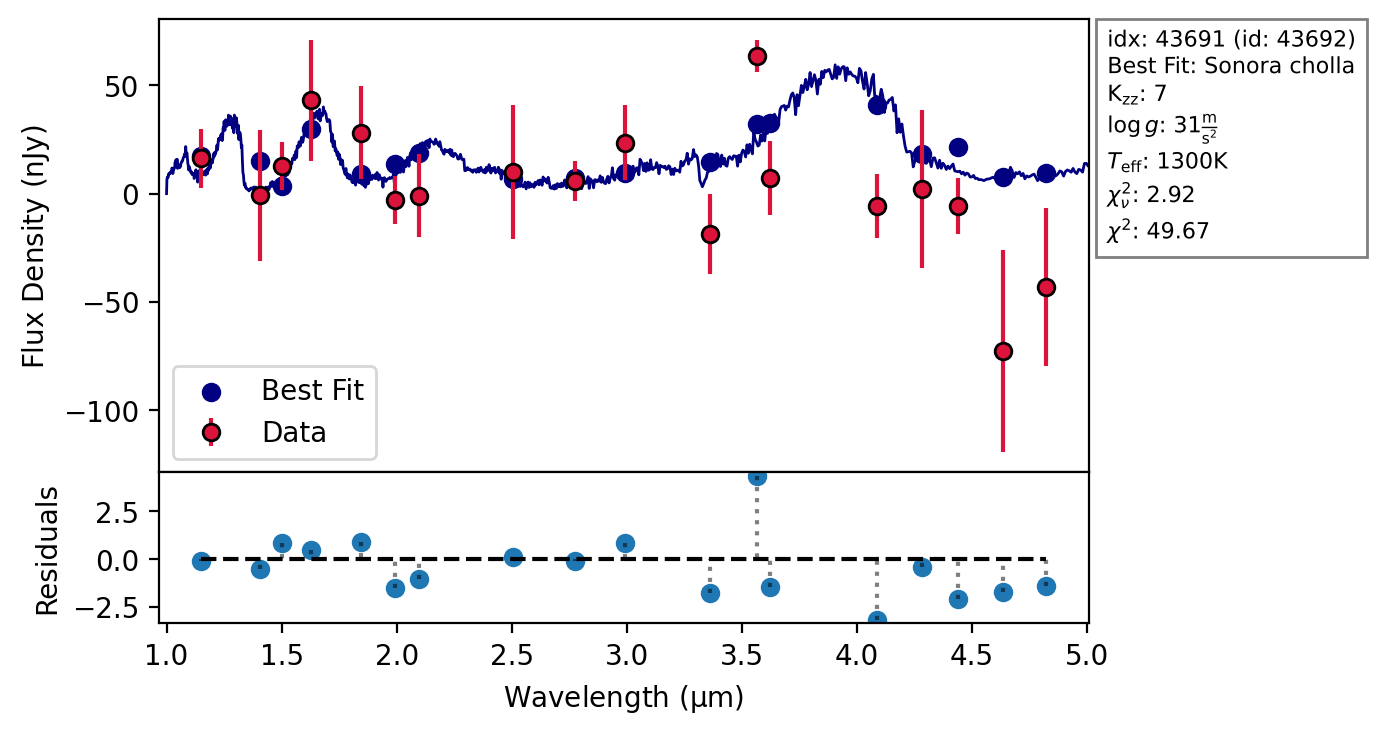

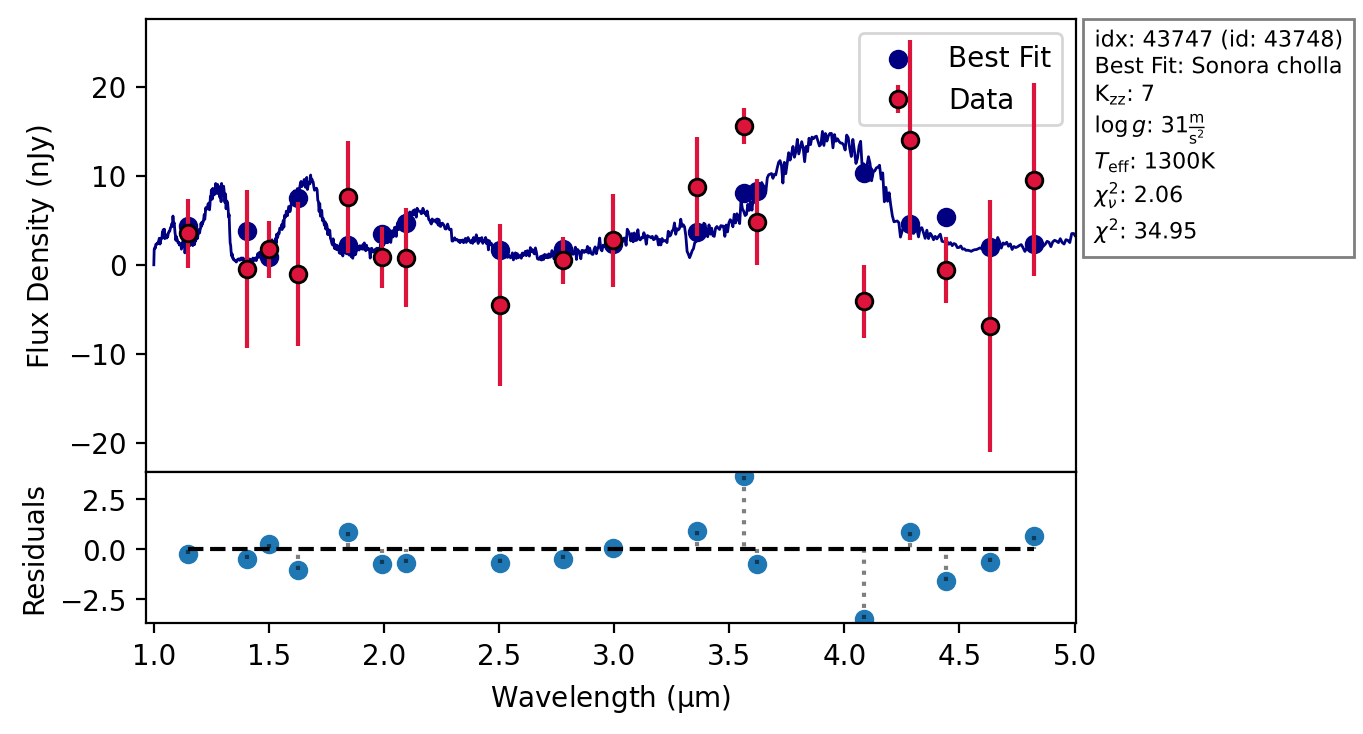

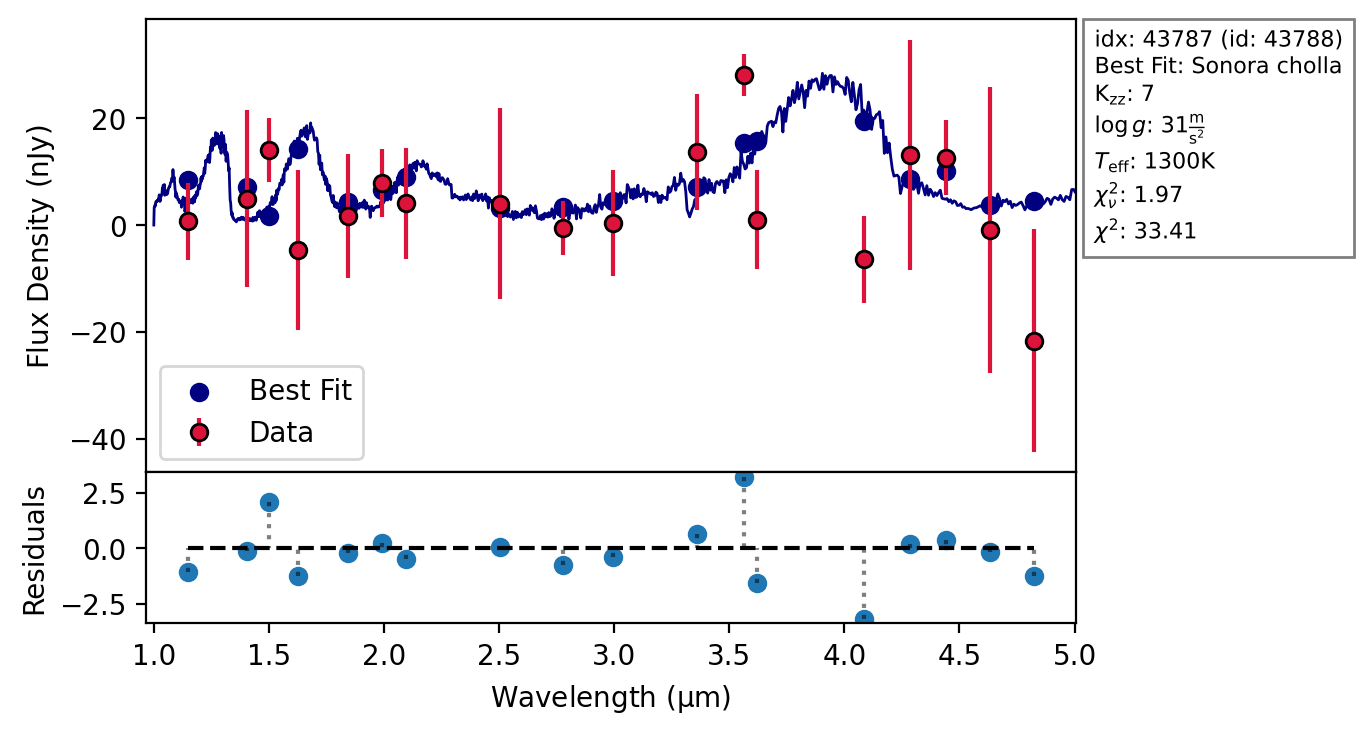

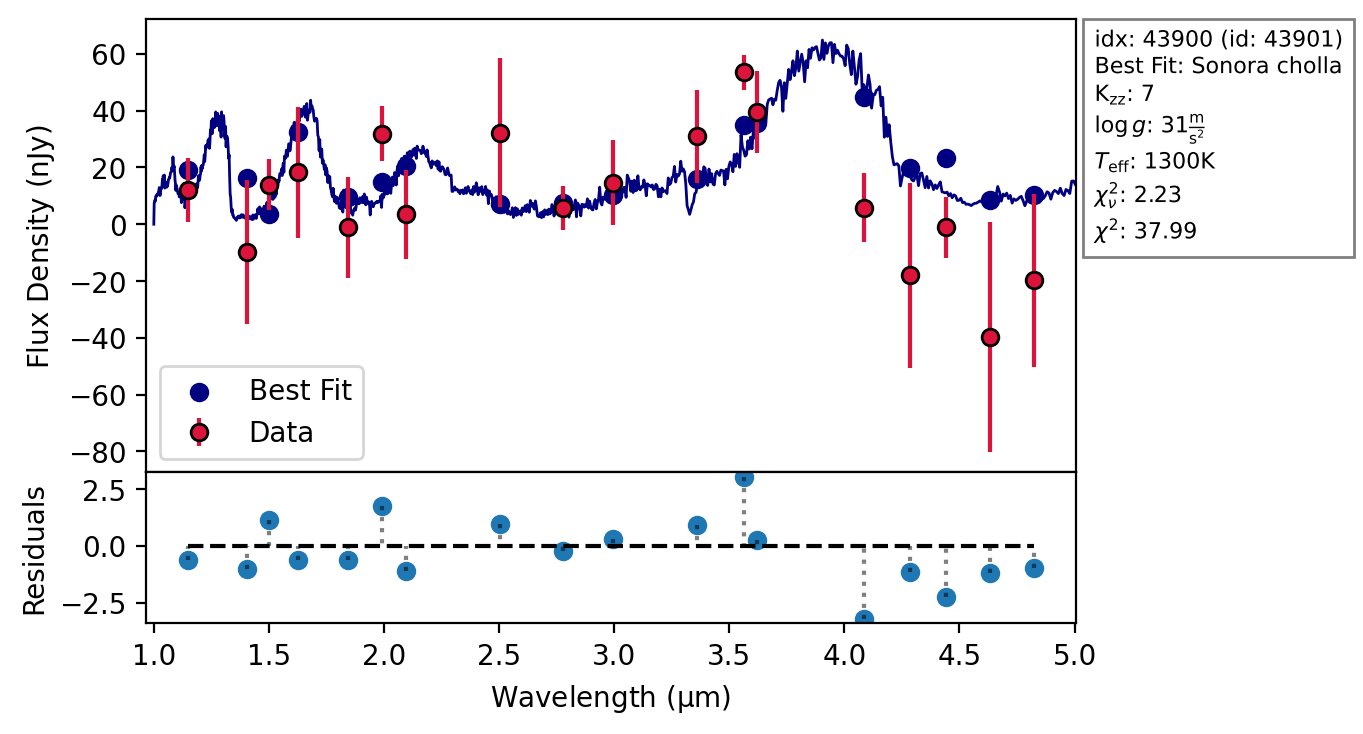

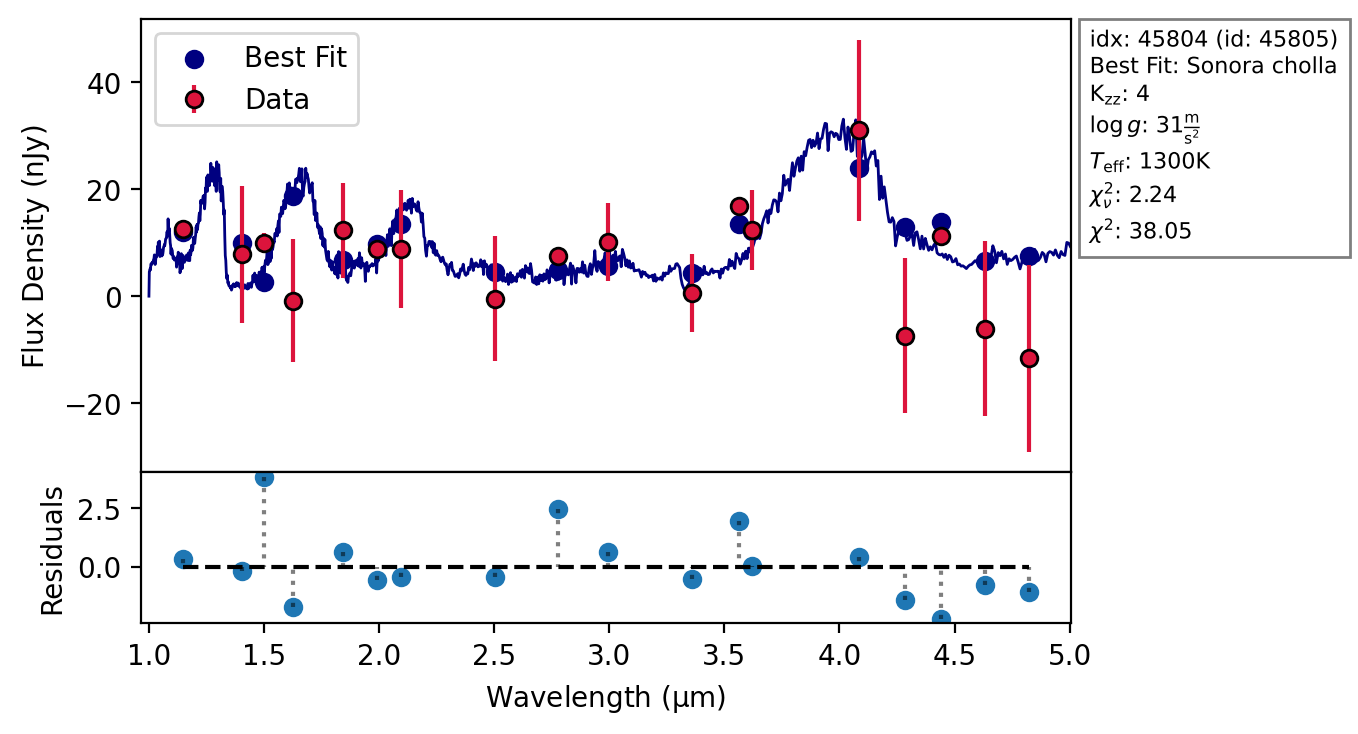

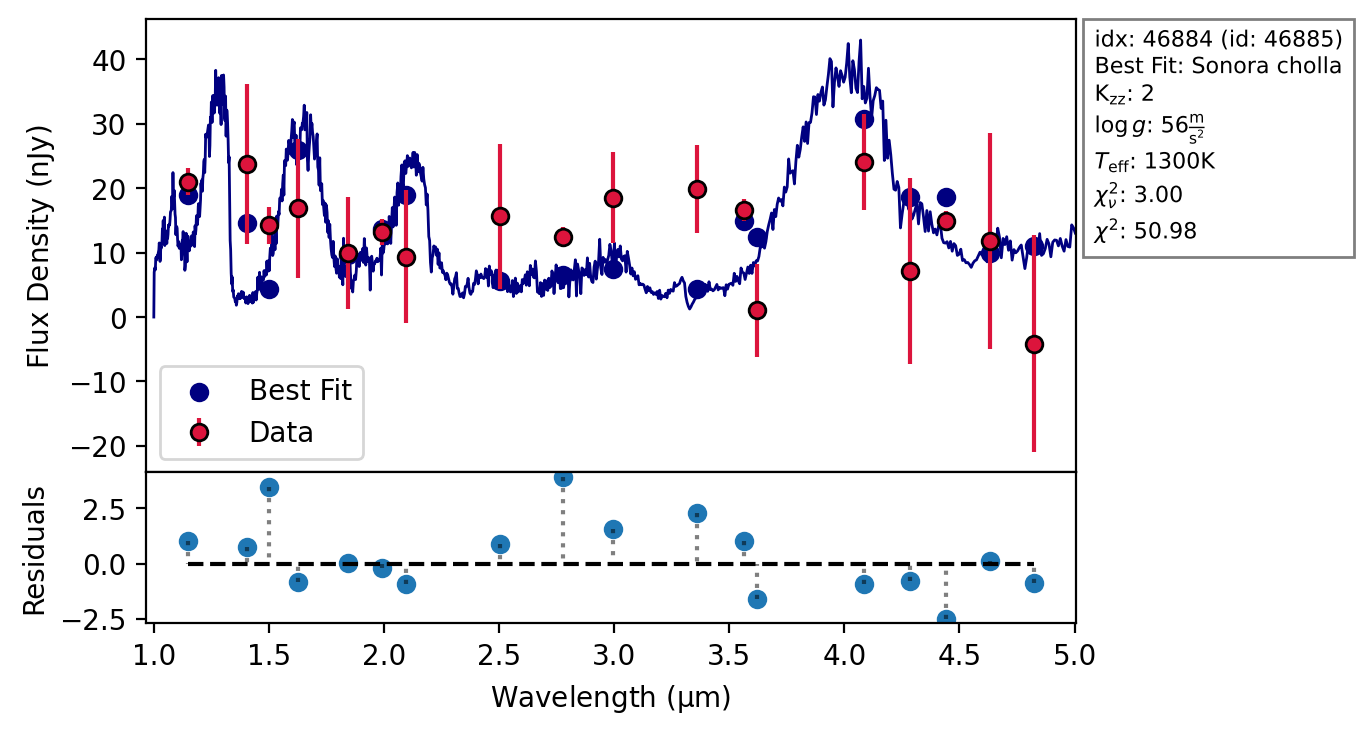

In [44]:
# Reduced chi2 less than 1, S/N in any 3 bands greater than 5, and all 27 filters used

mask = (s.star_min_chinu < 3) & (np.sum(flux.value/error.value > 8, axis=1) > 3) & (s.nusefilt > 15)
ids = np.arange(len(s.star_min_chinu))[mask]
print(len(ids))
for i in ids:
    s.plot_fit(idx=i, flux_unit=u.nJy)


In [5]:
galcen_frame = Galactocentric

coord = SkyCoord(ra=table['ra'][mask], dec=table['dec'][mask], unit=(u.deg, u.deg), distance=12.3*u.kpc)
dummy = SkyCoord(ra=table['ra'][mask], dec=table['dec'][mask], unit=(u.deg, u.deg), distance=0*u.kpc)

coords_galactocentric = coord.transform_to(galcen_frame)
coords_galactocentric_dummy = dummy.transform_to(galcen_frame)

coords_galactocentric_dummy.x, coords_galactocentric.x
coords_galactocentric_dummy.y, coords_galactocentric.y
coords_galactocentric_dummy.z, coords_galactocentric.z
            

(<Quantity [] kpc>, <Quantity [] kpc>)

/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:2079: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if idxs == 'all':


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

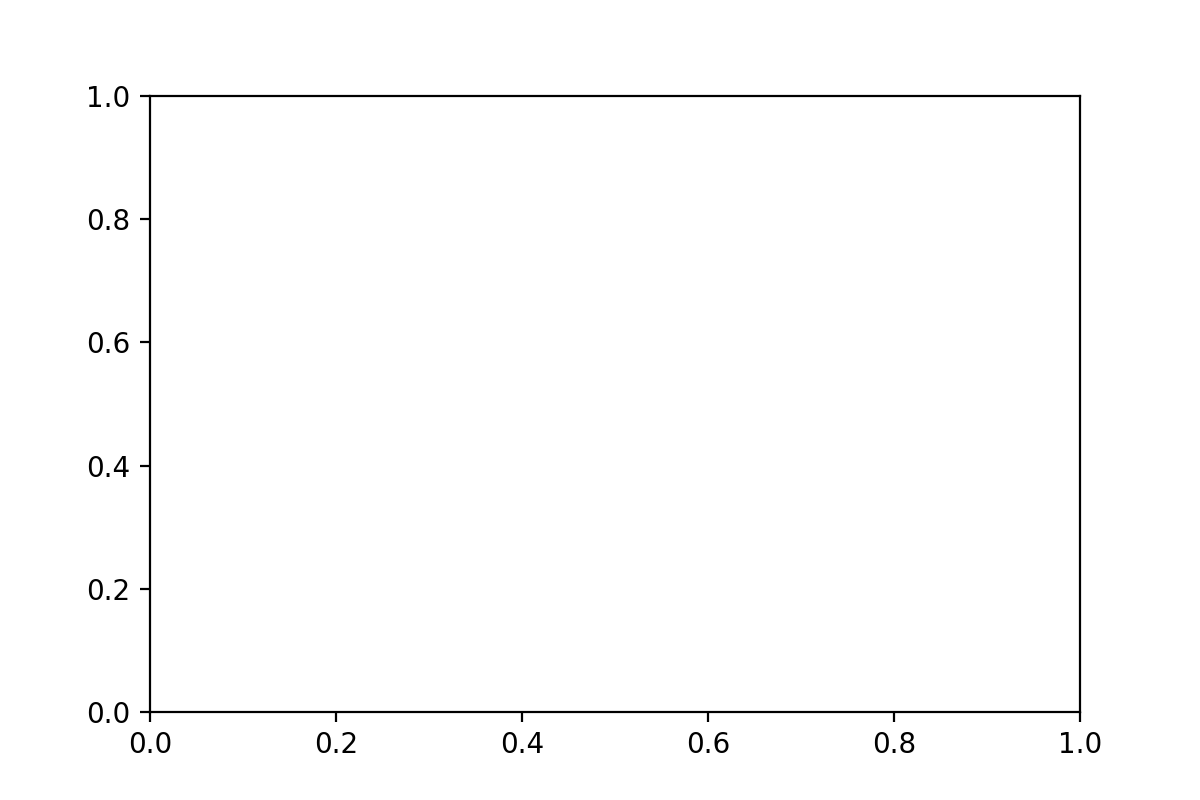

In [6]:
%matplotlib ipympl

ras = table['ra'][mask]
decs = table['dec'][mask]

s.plot_brown_dwarf_locations(idxs=ids, ra=ras, dec=decs, coord_system='galactocentric', plot_3d=False)

/raid/scratch/data/jwst/UNCOVER/UNCOVER_DR3/abell2744clu-grizli-v7.2-f162m-clear_drc_sci.fits


IndexError: index 21 is out of bounds for axis 0 with size 21

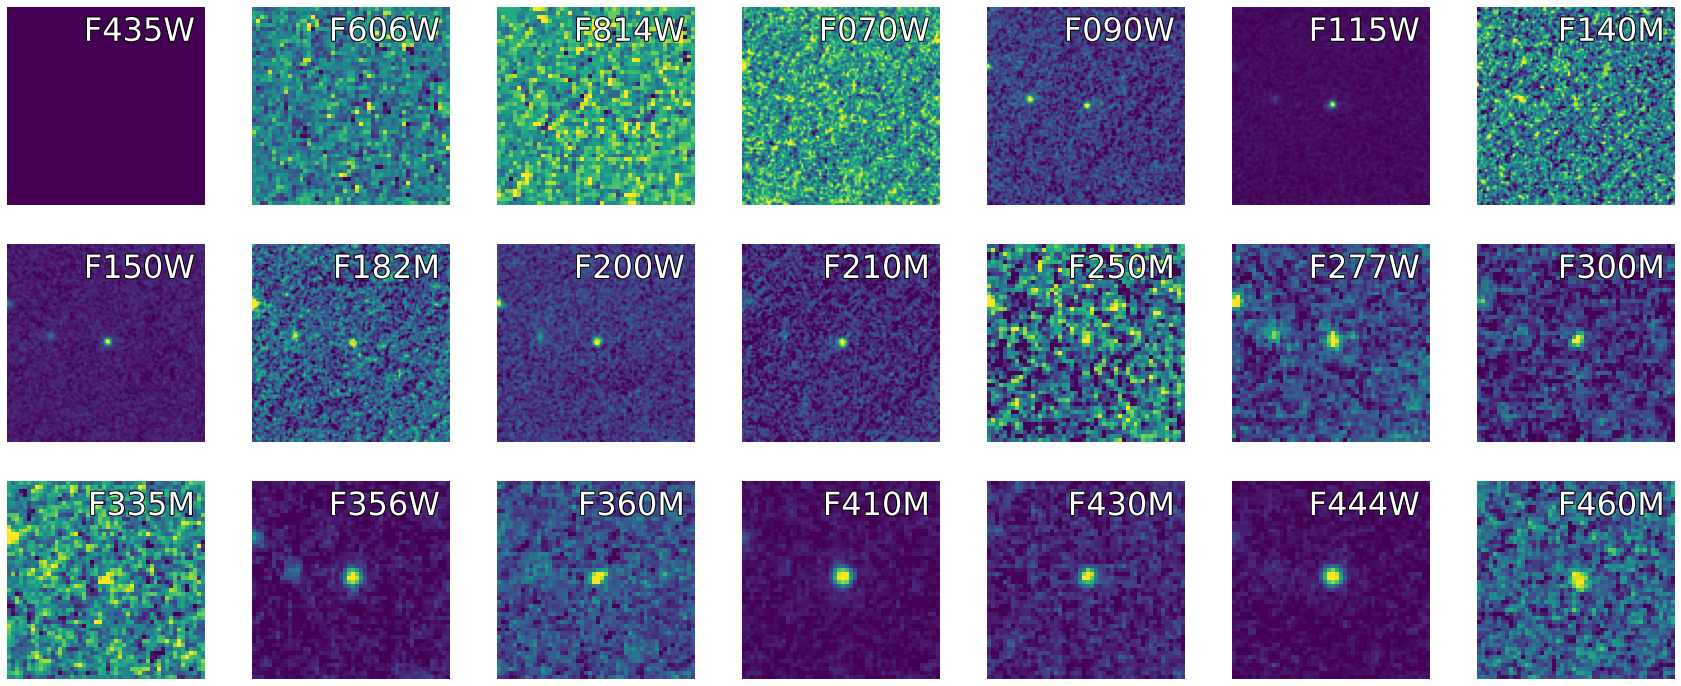

In [25]:
%matplotlib inline

image_folder = '/raid/scratch/data/jwst/UNCOVER/UNCOVER_DR3'

cutout_size_as = 2 * u.arcsec
id = 45661
scale = LinearStretch()

nrows = 3
fig, ax = plt.subplots(nrows, len(bands)//nrows, figsize=(4*len(bands)//nrows, 4.12*nrows))

ax = ax.flatten()

ax_pos = 0
for pos, band in enumerate(bands):
    image_name = f'{image_folder}/abell2744clu-grizli-v7.2-{band.lower()}-clear_drc_sci.fits'
    alt_image_name = f'{image_folder}/abell2744clu-grizli-v7.0-{band.lower()}_drz_sci.fits'
    alt_image_name2 = f'{image_folder}/abell2744clu-grizli-v7.1-{band.lower()}_drc_sci.fits'

    if os.path.exists(alt_image_name):
        image_name = alt_image_name
    elif os.path.exists(alt_image_name2):
        image_name = alt_image_name2

    if not os.path.exists(image_name):
        print(image_name)
        add = False
        continue
    else:
        add = True
    hdu = fits.open(image_name)
    wcs_im = WCS(hdu[0].header)
    
    pixel_scale = np.abs(hdu[0].header['CD1_1']) * u.deg
    cutout_size = int(cutout_size_as / pixel_scale)


    ra_coord = table['ra'][table['id'] == id]
    dec_coord = table['dec'][table['id'] == id]
    sky_pos = SkyCoord(ra_coord, dec_coord)                        
    pixel_coords = skycoord_to_pixel(sky_pos, wcs_im)
    x, y = pixel_coords[0][0], pixel_coords[1][0]
    data = np.array(hdu[0].section[int(y-cutout_size/2):int(y+cutout_size/2), int(x-cutout_size/2):int(x+cutout_size/2)])
    # get only middle 10x10 pixels
    data_crop = data[cutout_size//2-5:cutout_size//2+5, cutout_size//2-5:cutout_size//2+5]
    norm = ImageNormalize(data_crop, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
    ax[ax_pos].imshow(data, norm=norm, cmap='viridis', origin='lower')
    
    ax[ax_pos].text(0.95, 0.95, band.upper(), color='white', ha='right', va='top', transform=ax[ax_pos].transAxes, fontsize=32,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    ax[ax_pos].axis('off')    
    if add:
        ax_pos += 1


for i in range(ax_pos, len(ax)):
    fig.delaxes(ax[i])

# Remove horizontal space between axes
plt.subplots_adjust(hspace=0, wspace=0)

Match known UNCOVER Brown Dwarfs

In [4]:
names = ['UNCOVER BD1', 'UNCOVER BD2', 'UNCOVER BD3']
coords = ['J00140901-3022126','J00141114-3021585','J00140333-3021217']

coords_ra = [3.537529, 3.546420, 3.513891]
coords_dec = [-30.370169, -30.366245, -30.356024]

for i in range(len(names)):
    test = SkyCoord.from_name(coords[i])
    coords[i] = SkyCoord(ra=coords_ra[i], dec=coords_dec[i], unit=(u.deg, u.deg))
    print(coords[i].to_string('hmsdms'), test.to_string('hmsdms'), coords[i].separation(test).arcsec)

new_skycoord = SkyCoord(ra=[coord.ra.deg for coord in coords], dec=[coord.dec.deg for coord in coords], unit=(u.deg, u.deg))

# Match to catalog

all_catalog = SkyCoord(table['ra'], table['dec'], unit='deg')

idx, sep, _ = new_skycoord.match_to_catalog_sky(all_catalog)

# Closest match is idx[0] with sep[0]   

for i in range(len(names)):
    print(names[i], sep[i].arcsec, table['id'][idx[i]])

00h14m09.00696s -30d22m12.6084s 00h14m09.012s -30d22m12.612s 0.0653252136858905
00h14m11.1408s -30d21m58.482s 00h14m11.1432s -30d21m58.536s 0.0622960607508309
00h14m03.33384s -30d21m21.6864s 00h14m03.3336s -30d21m21.708s 0.021822236594214988
UNCOVER BD1 0.0068337720686782785 44489
UNCOVER BD2 0.0037720809545995645 45661
UNCOVER BD3 0.008146724421967648 51651


44489


27.24461902320015
29.050819733555105
27.85424978752622
45661
27.39617668937761
27.39496482290098
51651
28.40325949747285
29.613622095430326


/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1586: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[0].add_patch(FancyArrowPatch((wavs[i], error_3sigma), (wavs[i], error_3sigma+length), color='crimson', zorder=10, edgecolor='k', arrowstyle='-|>, scaleA=3', mutation_scale=8))


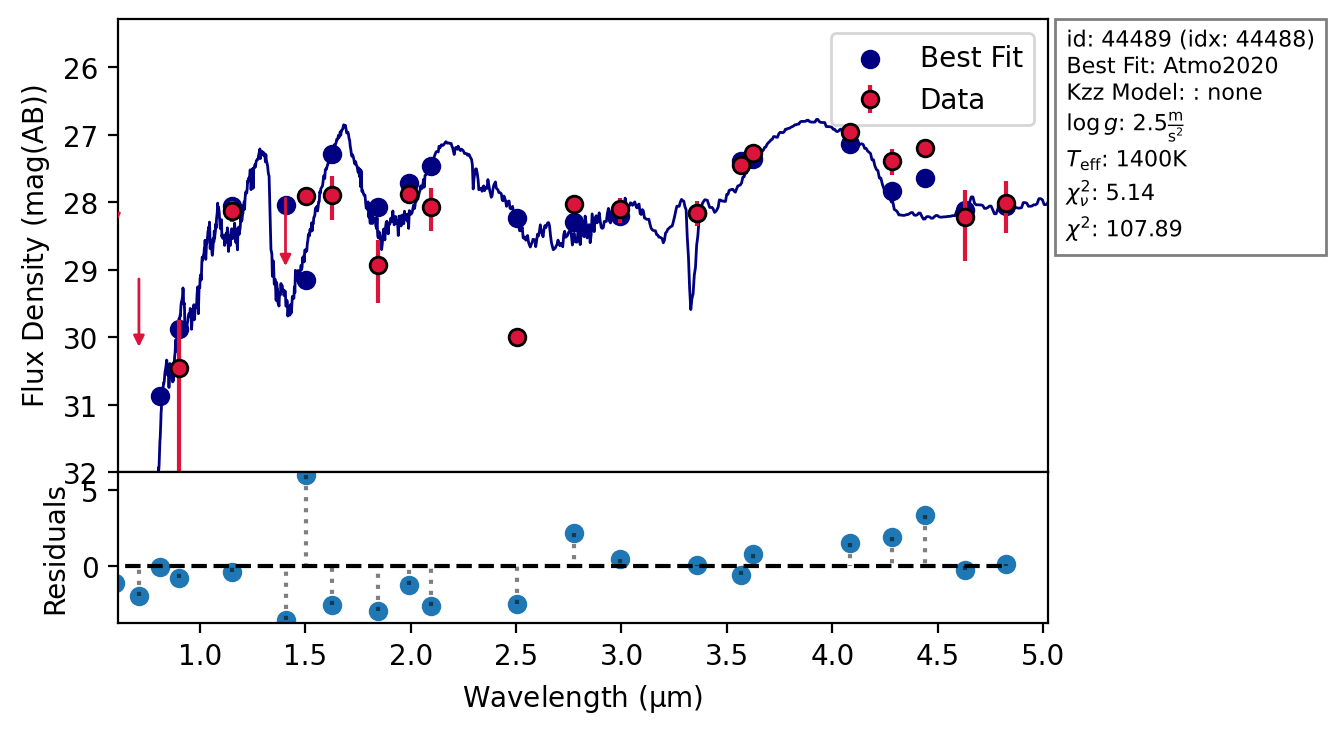

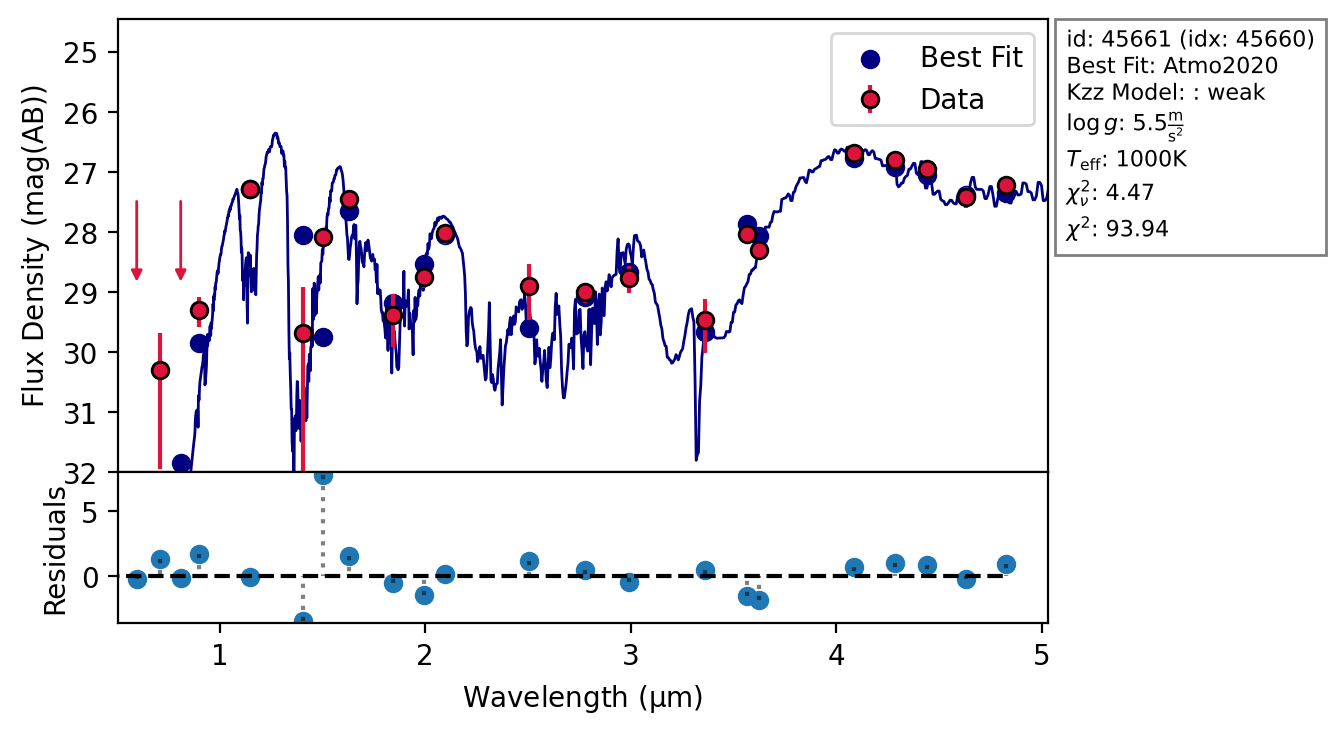

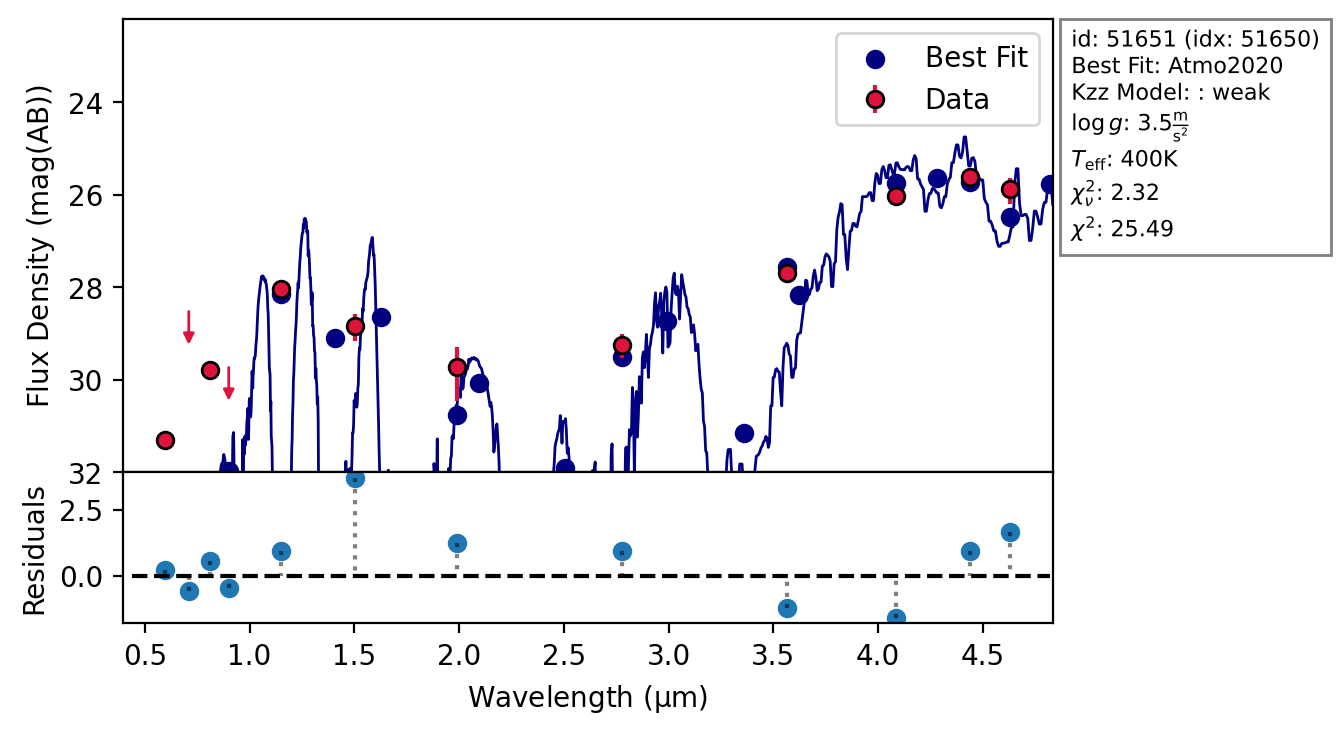

In [5]:
%matplotlib inline

for id in table['id'][idx]:
    print(id)
    s.plot_fit(cat_id=id, flux_unit=u.ABmag)

(<Figure size 1200x800 with 2 Axes>,
 array([<Axes: ylabel='Flux Density ($\\mathrm{nJy}$)'>,
        <Axes: xlabel='Wavelength ($\\mathrm{\\mu m}$)', ylabel='Residuals'>],
       dtype=object))

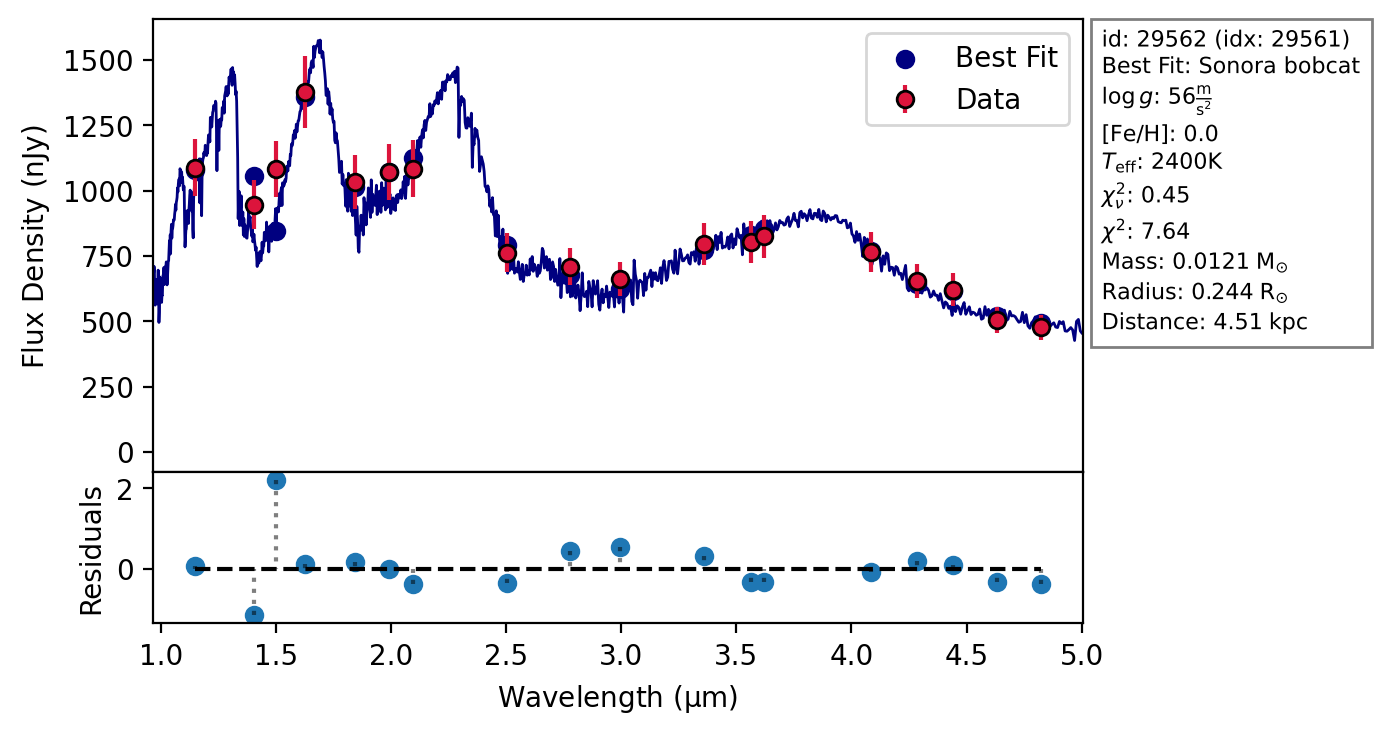

In [51]:
s.plot_fit(cat_id=29562)

In [2]:
s = StarFit(libraries=['ATMO2020'])


Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 418
